<a href="https://colab.research.google.com/github/Hitesh1912/Mercari-Price-Suggestion-Challenge/blob/master/RNN_model_DMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Pre-requisite to install before running the code

If you are installing any dependent libraries, please specify here as pre-req 
to install before running the notebook


1.   scikit-learn
2.   Keras


In [0]:
#run to install pre-req libraries
!pip install textstat


In [5]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)


In [0]:
from datetime import datetime 
start_real = datetime.now()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot_ng as pydot
from textstat import textstat

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten, Activation
# from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from nltk.corpus import stopwords
import math
# set seed
np.random.seed(123)

### Store the dataset

In [8]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge"))
input_folder = '/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/'

# Any results you write to the current directory are saved as output.

['train.tsv', 'test.tsv', 'train.pkl']


## 1. Loading Data

In [37]:
train_data = pd.read_csv(input_folder + 'train.tsv', sep='\t')
test_data = pd.read_csv(input_folder + 'test.tsv', sep='\t')
print("train shape",np.shape(train_data))
print("test shape",np.shape(test_data))
train_data.head()

train shape (1482535, 8)
test shape (693359, 7)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [97]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481658 entries, 0 to 1482534
Data columns (total 14 columns):
train_id             1481658 non-null int64
name                 1481658 non-null object
item_condition_id    1481658 non-null int64
category_name        1475344 non-null object
brand_name           1481658 non-null object
price                1481658 non-null float64
shipping             1481658 non-null int64
item_description     1481654 non-null object
desc_len             1481658 non-null int64
name_len             1481658 non-null int64
subcat_0             1481658 non-null object
subcat_1             1481658 non-null object
subcat_2             1481658 non-null object
target               1481658 non-null float64
dtypes: float64(2), int64(5), object(7)
memory usage: 169.6+ MB


In [98]:
train_data.describe()

,train_id,item_condition_id,price,shipping,desc_len,name_len,target
count,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06
mean,7.412429e+05,1.907323e+00,2.674928e+01,4.473266e-01,2.551959e+01,4.400937e+00,2.980807e+00
std,4.279713e+05,9.031762e-01,3.848908e+01,4.972179e-01,3.051796e+01,1.654781e+00,7.458991e-01
min,0.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.386294e+00
25%,3.705872e+05,1.000000e+00,1.000000e+01,0.000000e+00,7.000000e+00,3.000000e+00,2.397895e+00
50%,7.412365e+05,2.000000e+00,1.700000e+01,0.000000e+00,1.500000e+01,4.000000e+00,2.890372e+00
75%,1.111876e+06,3.000000e+00,2.900000e+01,1.000000e+00,3.100000e+01,6.000000e+00,3.401197e+00
max,1.482534e+06,5.000000e+00,2.000000e+03,1.000000e+00,2.450000e+02,1.700000e+01,7.601402e+00


In [99]:
train_data.price.describe().apply(lambda x: format(x, 'f'))

count    1481658.000000
mean          26.749280
std           38.489080
min            3.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2000.000000
Name: price, dtype: object

## 2. Exploratory Data Analysis

In [0]:
#FOR THE PURPOSE OF EDA

def fill_missing_data(data):
    data.category_name.fillna(value = "unk_cat1/unk_cat2/unk_cat3", inplace = True)
    if hasattr(data, 'brand_name'):
      data.brand_name.fillna(value = "unk_brand", inplace = True)   #comment this line if combining with name
    data.item_description.fillna(value = "unk_description", inplace = True)
    return data
#keeping copy of original data
train_data_copy = train_data.copy()

In [91]:
train_data_copy = fill_missing_data(train_data_copy)
# TODO Delete later, just used for verification
train_data_copy.nunique()

train_id             1481658
name                 1224593
item_condition_id          5
category_name           1288
brand_name            125963
price                    824
shipping                   2
item_description     1280669
desc_len                 229
name_len                  15
subcat_0                  11
subcat_1                 114
subcat_2                 871
target                   824
dtype: int64

In [92]:
# TODO Delete later, just used for verification
train_data_copy.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
desc_len             False
name_len             False
subcat_0             False
subcat_1             False
subcat_2             False
target               False
dtype: bool

In [94]:
train_data_copy = pd.concat([train_data_copy, train_data_copy.category_name.str.split('/', n = 2, expand=True).rename({0: 'cat_1', 1: 'cat_2', 2: 'cat_3'}, axis=1)], axis=1)
train_data_copy.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,desc_len,name_len,subcat_0,subcat_1,subcat_2,target,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB Cincinnati Reds T Shirt Size XL,10.0,1,No description yet,0,7,Men,Tops,T-shirts,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,36,4,Electronics,Computers & Tablets,Components & Parts,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,29,2,Women,Tops & Blouses,Blouse,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,32,3,Home,Home Décor,Home Décor Accents,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,5,4,Women,Jewelry,Necklaces,3.806662,Women,Jewelry,Necklaces


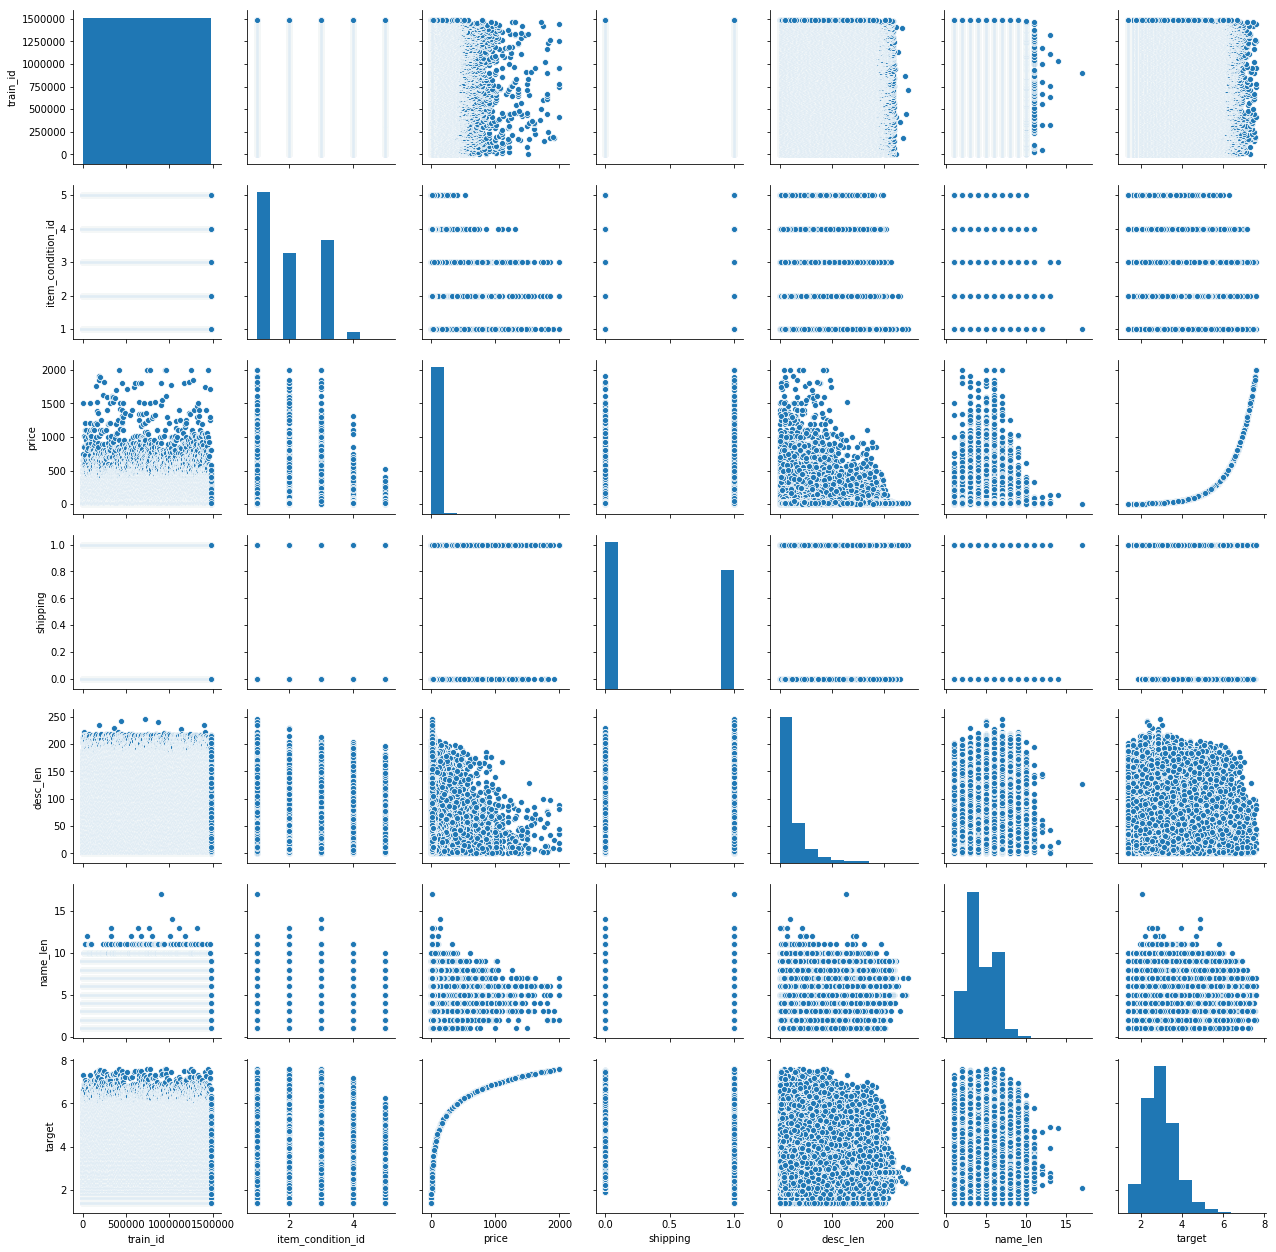

In [95]:
%%time
# Overall graph comparasin of all the features against each other
import seaborn as sns
sns.pairplot(train_data_copy)

### List of Categories to which a product belongs in the dataset




In [101]:
train_data_copy.cat_1.unique()

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'unk_cat1',
       'Handmade'], dtype=object)

There are 11 Main Categories in the dataset 


*   Men
*   Electronics
*   Women
*   Home
*   Sports & Outdoors
*   Vintage & Collectibles
*   Beauty
*   Other
*   HandMade
*   Women
*   Unspecified Category




### Price Distribution in the Dataset

In [102]:
train_data_copy.price.describe().apply(lambda x: format(x, 'f'))

count    1481658.000000
mean          26.749280
std           38.489080
min            3.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2000.000000
Name: price, dtype: object

The Price range in the data set starts from 0 to 2009 with the overall averge price the dataset being 26.7

Text(-0.08, 0.5, 'train_id')

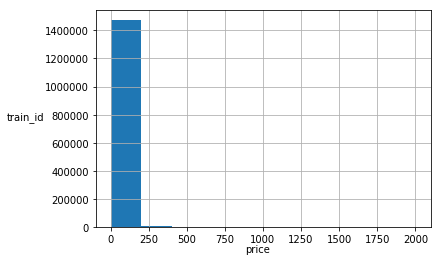

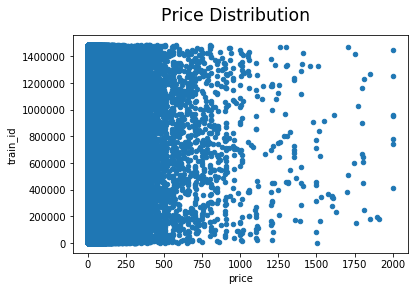

In [106]:
# Visualising the price distribution using graphs 
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
train_data_copy.price.hist()
train_data_copy.plot.scatter(x='price',y='train_id')
plt.suptitle('Price Distribution', ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'price', ha='center')
fig.text(-0.08, 0.5, 'train_id')

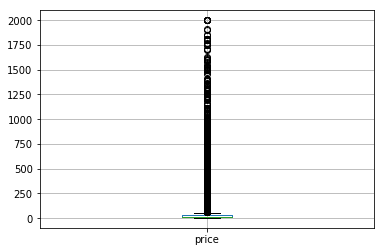

In [107]:
train_data_copy.boxplot(column=['price'])

Majority of the products sell within the 225 dollar scatter plot gives more observable distribution of price in dataset

### Brand Name and Price

In [108]:
# Over 4000 unique brands in the dataset
print("Unique Brands in Data Set :" +  str(train_data_copy.brand_name.unique().size))
print(train_data_copy.brand_name.describe())

Unique Brands in Data Set :125963
count     1481658
unique     125963
top       missing
freq       494994
Name: brand_name, dtype: object


In [109]:
# Most popular brands with most items for sale in dataset
brand_info = train_data_copy["brand_name"].value_counts()
bf = pd.DataFrame(brand_info).reset_index()
bf.columns = ['Brand Name', 'count']
bf[1:10]

,Brand Name,count
1,PINK,54053
2,Nike,53943
3,Victoria's Secret,48041
4,LuLaRoe,31070
5,Apple,17304
6,FOREVER 21,15173
7,Nintendo,14999
8,Lululemon,14569
9,Michael Kors,13939


Text(0, 0.5, 'Avg Selling Price in $')

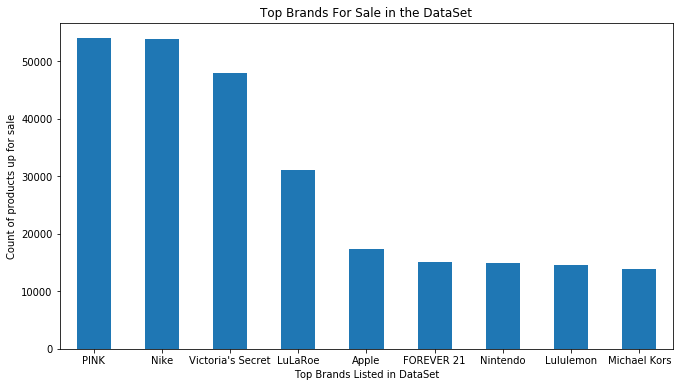

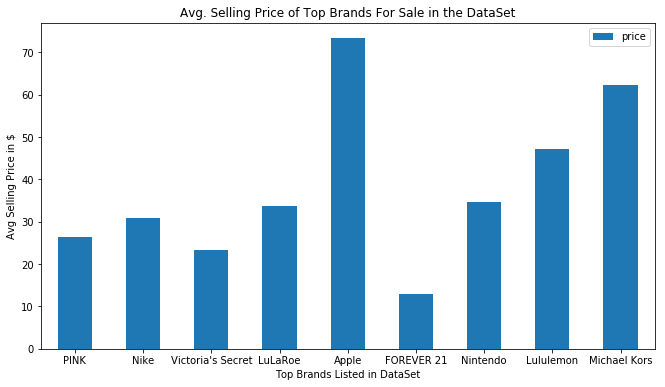

In [110]:
# Plotting a graph for count plot of popular brand and avg selling price of these brands

# Count Plot
ax = brand_info[1:10].plot.bar(y="count" , rot=0,figsize=(11, 6), title="Top Brands For Sale in the DataSet")
ax.set_xlabel("Top Brands Listed in DataSet")
ax.set_ylabel("Count of products up for sale")

# Popular Brand average Selling Price
bi = train_data_copy.pivot_table('price', index='brand_name', aggfunc='mean')
brand_info[1:10].tolist()
tb = bi.loc[bf[1:10]['Brand Name']]
ax = tb.plot.bar(y='price', rot=0,figsize=(11, 6),title="Avg. Selling Price of Top Brands For Sale in the DataSet")
ax.set_xlabel("Top Brands Listed in DataSet")
ax.set_ylabel("Avg Selling Price in $")

By Observing the graph for Count plot and Avg Selling Price for top brands we can see that


*   Clothing brands like PINK, Nike, Victoria's Secret etc. have the most products on sale. and since cloths don't cost as muc has electronics or luxury items their product count is high but average selling price is low
*   Electronic brands like Apple, Nintendo have lower product count as compared to clothing brands but have a higher average selling price, this makes sense as electronics products are more expensive then clothing
*  Micheal Kors which is luxury brand, has lower products on sale in the dataset but has a high avg. selling price since luxury brands have a higher selling price



In [116]:
bi = train_data_copy.pivot_table('price', index='brand_name', aggfunc='mean')

# Listing brands which have the higest average selling price for a product

bi.sort_values(by=['price'],ascending=False).head()

,price
brand_name,
Vs2/I 1ct Diamond Engagement Ring,2000.0
Chanel J12 H0682 Wrist Watch for Women,1999.0
14kt 14k Gold Diamond Ring PLUS,1800.0
Chanel Purse Reserved.,1750.0
IPad Air Pro,1400.0


Text(0, 0.5, 'Avg Selling Price in $')

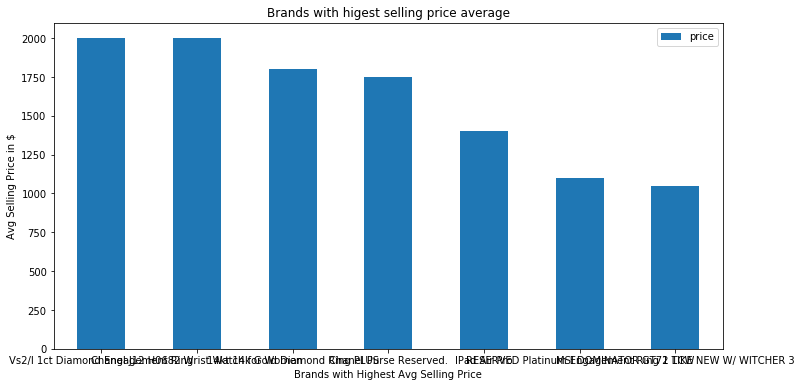

In [112]:
# Plotting graph comparing selling price of products to the most listed (popular) brand in the dataset
ax = bi.sort_values(by=['price'],ascending=False)[0:7].plot.bar(y='price', rot=0,figsize=(12, 6),title="Brands with higest selling price average")
ax.set_xlabel("Brands with Highest Avg Selling Price")
ax.set_ylabel("Avg Selling Price in $")


#BUG



*   Brands like Demdaco (exclusive range of artist-driven gifts), Proenza Schouler (designer brand) naturally have higher selleing price since they are part of luxury brand and correspondingly their count of products for sale is also less oweing to high price and affodability.





### Main Category and Price 


In [114]:
# Most popular brands with most items for sale in dataset
category_info = train_data_copy["cat_1"].value_counts()
df = pd.DataFrame(category_info).reset_index()
df.columns = ['Category Name', 'count']
df[1:10]

,Category Name,count
1,Beauty,207725
2,Kids,171555
3,Electronics,122632
4,Men,93609
5,Home,67831
6,Vintage & Collectibles,46519
7,Other,45329
8,Handmade,30835
9,Sports & Outdoors,25322


ValueError: ignored

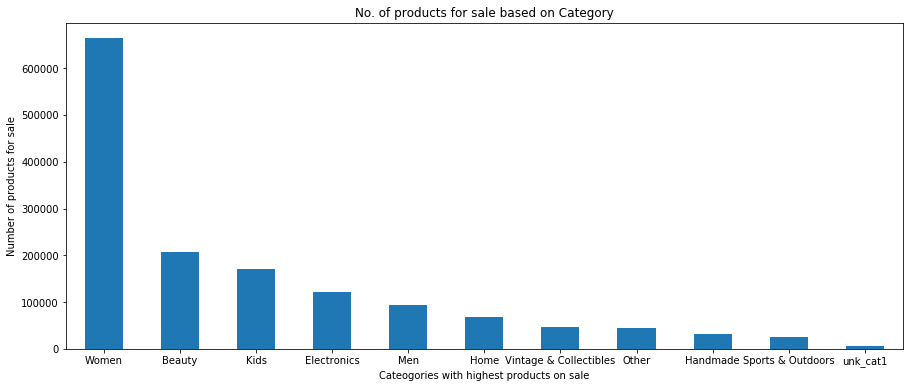

In [117]:
# Count plot of Category Names and their a plot of their average selling price

# Count Plot
ax = category_info.plot.bar(rot=0,figsize=(15, 6),title="No. of products for sale based on Category")
ax.set_xlabel("Cateogories with highest products on sale")
ax.set_ylabel("Number of products for sale")

# Average Selling Price
cat_data = pd.concat([train_data_copy, train_data_copy.category_name.str.split('/', n = 2, expand=True).rename({0: 'cat_1', 1: 'cat_2', 2: 'cat_3'}, axis=1)], axis=1)
ci = cat_data.pivot_table('price', index='cat_1', aggfunc='mean')
ci.plot.bar(y='price', rot=0,figsize=(15, 6),title=" Avg. selling price based off category types")
ax.set_xlabel("Cateogories with highest products on sale")
ax.set_ylabel("AVerage Selling Price")


From the Count plot and Avg selling price graph plot for Main category from data set it can be observed that
*   Clothing/Shoe/Bags etc. have the highest no. of products on sale (Women, Beauty,Kids,Men) Vategoty. 
*   Categories such as Electronics, Sports and Vintage and Collectibles have lower products on sale but have higher sellnig price as naturally Vintage and Electronics tend to cost more than clothing



### Shipping and Price 

Text(-0.08, 0.5, 'Products')

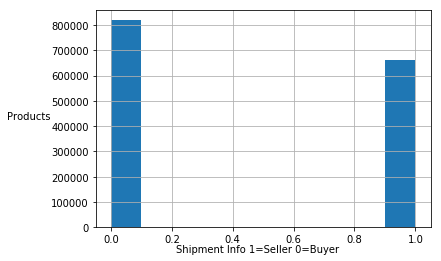

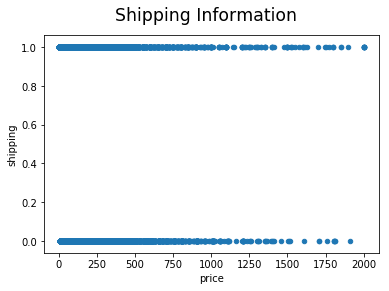

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

train_data_copy.shipping.hist()
train_data_copy.plot.scatter(x='price',y='shipping')

# Visualising the shipping distribution using graphs 
plt.suptitle('Shipping Information', ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Shipment Info 1=Seller 0=Buyer', ha='center')
fig.text(-0.08, 0.5, 'Products')

From the above graph it can be observed that 


*   There are more items for which the buyer has to pay for shipping (shipping =0) vs compared to when seller pays for the shipping (shipping =1)
*   Avg. Selling price seems to be uniform between the two methods of shipment.



### WORD CLOUD

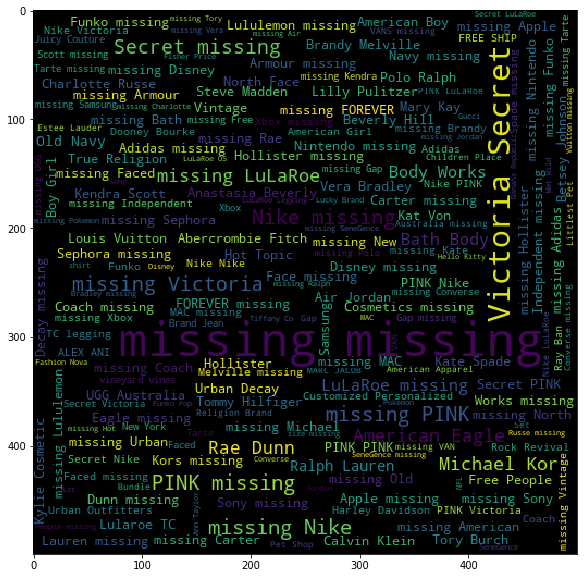

In [119]:
#!pip install wordcloud
from wordcloud import WordCloud
import os
wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(train_data_copy.brand_name.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

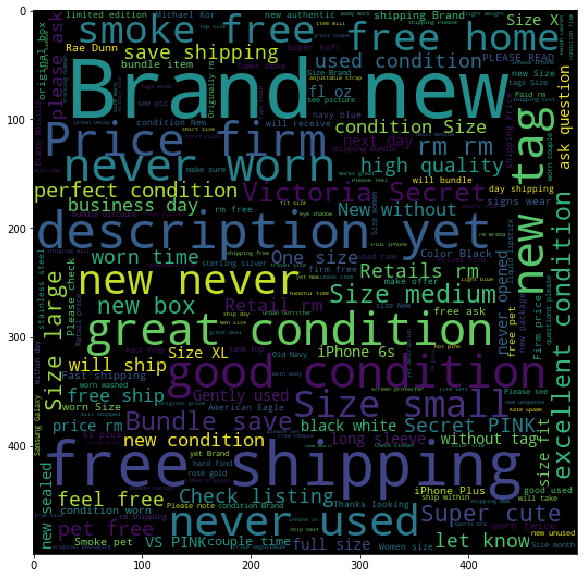

In [120]:
from wordcloud import WordCloud
import os

wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(train_data_copy.item_description.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

##  3. Data Processing

As per Mercari policy, it does not allow postings below 3 so below that seems to be an error. Removing them helps the models.

In [125]:
# Remove low prices, anything below 3
train_data = train_data.drop(train_data[(train_data.price < 3.0)].index)
train_data.shape

(1481658, 14)

In [39]:
train_data = train_data.drop(train_data[(train_data.price > 2000)].index)
train_data.shape

(1481658, 8)

#### Feature Engineering -

In [0]:
# calculate readability score from the item_description attribute. The reasoning behind this is that a good product listing will be easy to read an concise. 
# train_data['item_description_readability_score'] = train_data['item_description'].apply(lambda x: textstat.gunning_fog(x) if x is not '' and x.lower()!='unk' else 999)
ddata = dd.from_pandas(train_data, npartitions=2)
train_data['item_description_readability_score'] = ddata['item_description'].apply(lambda x: textstat.gunning_fog(x) if x is not '' and x.lower()!='no description yet' else 99, meta=(None, 'float64')).compute(scheduler='multiprocessing')

#### Important observation:

The length of the description, that is the raw number of words used, does have some correlation with price. 

The RNN might find this out on it's own, but since a max depth is used to save computations, it does not always know. 

Description length clearly helps the model, name length may be not so much. Does not hurt the models so leaving name length.

In [126]:
%%time
# get name and description lengths
def wordCount(text):
    try:
        if text == 'No description yet':
            return 0
        else:
            text = text.lower()
            words = [w for w in text.split(" ")]
            return len(words)
    except: 
        return 0
train_data['desc_len'] = train_data['item_description'].apply(lambda x: wordCount(x))
test_data['desc_len'] = test_data['item_description'].apply(lambda x: wordCount(x))
train_data['name_len'] = train_data['name'].apply(lambda x: wordCount(x))
test_data['name_len'] = test_data['name'].apply(lambda x: wordCount(x))
train_data.head()

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s


 we split the category_name into 3 parts. Our models can get more information this way. 

In [41]:
 %%time
# split category name into 3 parts
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
train_data['subcat_0'], train_data['subcat_1'], train_data['subcat_2'] = \
zip(*train_data['category_name'].apply(lambda x: split_cat(x)))
train_data['subcat_0'], train_data['subcat_1'], train_data['subcat_2'] = \
zip(*train_data['category_name'].apply(lambda x: split_cat(x)))

CPU times: user 18 s, sys: 700 ms, total: 18.7 s
Wall time: 18.7 s


#### Handling sparse data in brand_name
The brand name data is sparse, missing over 600,000 values. This gets *some* of those values back by checking their names. However, It does not seem to help the models either way at this point. An *exact* name match against all_brand names will find about 3000 of these. We can be pretty confident in these. At the other extreme, we can search for *any* matches throughout all words in name. This finds over 200,000 but a lot of these are incorrect. Can land somewhere in the middle by either keeping cases or trimming out some of the 5000 brand names.

For example, PINK is a brand by victoria secret. If we remove case, then almost all *pink* items are labeled as PINK brand. The other issue is that some of the "brand names" are not brands but really categories like "Boots" or "Keys". 

*Currently, checking every word in name of a case-sensitive match does best. This gets around 137,000 finds while avoiding the problems with brands like PINK.*

In [42]:
# %%time
# attempt to find missing brand names
# train_df['name'] = train_df.name.str.lower()
# train_df['brand_name'] = train_df.brand_name.str.lower()
# test_df['name'] = test_df.name.str.lower()
# test_df['brand_name'] = test_df.brand_name.str.lower()

full_set = pd.concat([train_data,test_data])
all_brands = set(full_set['brand_name'].values)
train_data.brand_name.fillna(value="missing", inplace=True)
train_data.brand_name.fillna(value="missing", inplace=True)

# get to finding!
premissing = len(train_data.loc[train_data['brand_name'] == 'missing'])
def brandfinder(line):
    brand = line[0]
    name = line[1]
    namesplit = name.split(' ')
    if brand == 'missing':
        for x in namesplit:
            if x in all_brands:
                return name
    if name in all_brands:
        return name
    return brand
train_data['brand_name'] = train_data[['brand_name','name']].apply(brandfinder, axis = 1)
train_data['brand_name'] = train_data[['brand_name','name']].apply(brandfinder, axis = 1)
found = premissing-len(train_data.loc[train_data['brand_name'] == 'missing'])
print(found)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


137342


#### Standard split the train test for validation and Normalize the price using log

In [0]:
#save the dataset using pickle
train_data.to_pickle(input_folder + 'train_data.pkl') 

In [0]:
# Load saved preprocessed train data and skip previous runs
train_data = pd.read_pickle(input_folder + 'train_data.pkl')

In [43]:
# Scale target variable to log.
train_data["target"] = np.log1p(train_data.price)

# Split training examples into train/dev examples.
train_df, dev_df = train_test_split(train_data, random_state=123, train_size=0.99)

# Calculate number of train/dev/test examples.
n_trains = train_df.shape[0]
n_devs = dev_df.shape[0]
n_tests = test_data.shape[0]
print("Training on", n_trains, "examples")
print("Validating on", n_devs, "examples")
print("Testing on", n_tests, "examples")

Training on 1466841 examples
Validating on 14817 examples
Testing on 693359 examples


In [44]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,desc_len,name_len,subcat_0,subcat_1,subcat_2,target
131860,131860,Broncos Peyton manning youth jersey,2,Sports & Outdoors/Fan Shop/NFL,missing,23.0,1,Size is youth XL new with tags fully stitched ...,14,5,Sports & Outdoors,Fan Shop,NFL,3.178054
436335,436335,Fitbit Flex Band - Black with Clasp,1,Sports & Outdoors/Exercise/Fitness accessories,Fitbit Flex Band - Black with Clasp,8.0,1,**ONE SIZE FITS MOST** FITS FITBIT FLEX ONLY- ...,106,7,Sports & Outdoors,Exercise,Fitness accessories,2.197225
1334947,1334947,2x Apple EarPods Original Sealed Box,1,Electronics/Cell Phones & Accessories/Headsets,Apple,20.0,1,2x Brand new Apple Headphones w/ Remote and Mi...,22,6,Electronics,Cell Phones & Accessories,Headsets,3.044522
585261,585261,Pierce the veil tshirt,3,Women/Tops & Blouses/T-Shirts,Hot Topic,10.0,1,A guys shirt for sure I would guess the size i...,22,4,Women,Tops & Blouses,T-Shirts,2.397895
508228,508228,White fizzy northface.,2,Women/Athletic Apparel/Jackets,The North Face,26.0,0,Like new. Wore a few times. size small. I wear...,22,3,Women,Athletic Apparel,Jackets,3.295837


In [50]:
# Concatenate train - dev - test data for easy to handle
full_df = pd.concat([train_df, dev_df, test_data])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Fill missing data
Note:
replacing 'No description yet' with "missing"  in item_description helps the model a bit by treating it the same as the NA values

In [67]:
%%time

# Filling missing values
def fill_missing_values(df):
    df.category_name.fillna(value="missing", inplace=True)
    df.brand_name.fillna(value="missing", inplace=True)
    df.item_description.fillna(value="missing", inplace=True)
    df.item_description.replace('No description yet',"missing", inplace=True)
    df.subcat_0.fillna(value="missing", inplace=True)
    df.subcat_1.fillna(value="missing", inplace=True)
    df.subcat_2.fillna(value="missing", inplace=True)
    return df

print("Filling missing data...")
full_df = fill_missing_values(full_df)
print(full_df.category_name[1])

Filling missing data...
1    Electronics/Computers & Tablets/Components & P...
1              Other/Office supplies/Shipping Supplies
Name: category_name, dtype: object
CPU times: user 2.17 s, sys: 148 ms, total: 2.32 s
Wall time: 2.32 s


[NEED TO CHANGE]

### Convert Categorical features into continuous features


The columns name, item_condition_id, category_name, brand_name have categorical values. Categorical values can be converted to One Hot Encoding to feed into a machine learning model. 

*The column item_condition_id has fixed 5 unique values and we will transform that using OHE.*

The other remaining variables do not have fixed unique values, that can be problematic in OHE if the test dataset has new unique values/categories. These other variables alo have a large number of unique values, and this will create a very sparse matrix. Due to these problems, we will not transform them to OHE.

In [68]:
%%time

print("Processing categorical data...")
le = LabelEncoder()
# full_df.category = full_df.category_name
le.fit(full_df.category_name)
full_df['category'] = le.transform(full_df.category_name)

le.fit(full_df.brand_name)
full_df.brand_name = le.transform(full_df.brand_name)

le.fit(full_df.subcat_0.astype(str))
full_df.subcat_0 = le.transform(full_df.subcat_0)

le.fit(full_df.subcat_1.astype(str))
full_df.subcat_1 = le.transform(full_df.subcat_1)

le.fit(full_df.subcat_2.astype(str))
full_df.subcat_2 = le.transform(full_df.subcat_2)

del le


Processing categorical data...
CPU times: user 4.81 s, sys: 174 ms, total: 4.99 s
Wall time: 4.98 s


### Process text data
From here til the end of the RNN model are some commented out code lines when I used a short RNN layer to process category_name. Using the 3 subcats makes a better model but can sometimes be slightly slower.

In [69]:

%%time

print("Transforming text data to sequences...")
raw_text = np.hstack([full_df.item_description.str.lower(), full_df.name.str.lower(), full_df.category_name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

print("   Transforming text to sequences...")
full_df['seq_item_description'] = tok_raw.texts_to_sequences(full_df.item_description.str.lower())
full_df['seq_name'] = tok_raw.texts_to_sequences(full_df.name.str.lower())
# full_df['seq_category'] = tok_raw.texts_to_sequences(full_df.category_name.str.lower())

del tok_raw

Transforming text data to sequences...
   Fitting tokenizer...
   Transforming text to sequences...
CPU times: user 3min 52s, sys: 806 ms, total: 3min 53s
Wall time: 3min 53s


In [73]:
full_df['seq_name'][:5]

131860      [5208, 10061, 10806, 831, 708]
436335     [1615, 2088, 501, 26, 10, 1710]
1334947     [853, 387, 3778, 203, 332, 76]
585261                [5945, 3, 4143, 839]
508228                   [79, 10686, 3243]
Name: seq_name, dtype: object

In [0]:
full_df.to_pickle(input_folder + 'full_df.pkl')

#### constants

In [84]:
MAX_NAME_SEQ = 10 #17
MAX_ITEM_DESC_SEQ = 75 #269
MAX_CATEGORY_SEQ = 8 #8
MAX_TEXT = np.max([
    np.max(full_df.seq_name.max()),
    np.max(full_df.seq_item_description.max()),
#     np.max(full_df.seq_category.max()),
]) + 100
MAX_CATEGORY = np.max(full_df.category.max()) + 1
MAX_BRAND = np.max(full_df.brand_name.max()) + 1
MAX_CONDITION = np.max(full_df.item_condition_id.max()) + 1
MAX_DESC_LEN = int(np.max(full_df.desc_len.max()) + 1)
MAX_NAME_LEN = int(np.max(full_df.name_len.max()) + 1)
MAX_SUBCAT_0 = np.max(full_df.subcat_0.max()) + 1
MAX_SUBCAT_1 = np.max(full_df.subcat_1.max()) + 1
MAX_SUBCAT_2 = np.max(full_df.subcat_2.max()) + 1


print(MAX_CATEGORY)
print(MAX_TEXT)
print(MAX_BRAND)
print(MAX_CONDITION)
print(MAX_DESC_LEN) #bug convert to int
print(MAX_NAME_LEN) #bug convert to int
print(MAX_SUBCAT_0)
print(MAX_SUBCAT_1)
print(MAX_SUBCAT_2)

1311
322020
126428
6
246
18
12
115
872


In [82]:
## GET DATA FOR RNN

%%time

def get_rnn_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'brand_name': np.array(dataset.brand_name),
        'category': np.array(dataset.category),
#         'category_name': pad_sequences(dataset.seq_category, maxlen=MAX_CATEGORY_SEQ),
        'item_condition': np.array(dataset.item_condition_id),
        'num_vars': np.array(dataset[["shipping"]]),
        'desc_len': np.array(dataset[["desc_len"]]),
        'name_len': np.array(dataset[["name_len"]]),
        'subcat_0': np.array(dataset.subcat_0),
        'subcat_1': np.array(dataset.subcat_1),
        'subcat_2': np.array(dataset.subcat_2),
    }
    return X

train = full_df[:n_trains]
dev = full_df[n_trains:n_trains+n_devs]
test = full_df[n_trains+n_devs:]

X_train = get_rnn_data(train)
Y_train = train.target.values.reshape(-1, 1)

X_dev = get_rnn_data(dev)
Y_dev = dev.target.values.reshape(-1, 1)

X_test = get_rnn_data(test)

CPU times: user 20.1 s, sys: 17.8 ms, total: 20.1 s
Wall time: 20.2 s


In [0]:


def root_mean_squared_logarithmic_error(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1)+0.0000001)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)+0.0000001)

## 4. Data modeling

### RNN Model

This section will use RNN Model to solve the competition with following steps:

1. Define RNN model
1. Fitting RNN model on training examples
1. Evaluating RNN model on dev examples
1. Make prediction for test data using RNN model

### BUILD RNN MODEL

In [85]:
# set seed again in case testing models adjustments by looping next 2 blocks
np.random.seed(123)

def new_rnn_model(lr=0.001, decay=0.0):
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
#     category = Input(shape=[1], name="category")
#     category_name = Input(shape=[X_train["category_name"].shape[1]], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    desc_len = Input(shape=[1], name="desc_len")
    name_len = Input(shape=[1], name="name_len")
    subcat_0 = Input(shape=[1], name="subcat_0")
    subcat_1 = Input(shape=[1], name="subcat_1")
    subcat_2 = Input(shape=[1], name="subcat_2")

    # Embeddings layers (adjust outputs to help model)
    emb_name = Embedding(MAX_TEXT, 20)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
#     emb_category_name = Embedding(MAX_TEXT, 20)(category_name)
#     emb_category = Embedding(MAX_CATEGORY, 10)(category)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_desc_len = Embedding(MAX_DESC_LEN, 5)(desc_len)
    emb_name_len = Embedding(MAX_NAME_LEN, 5)(name_len)
    emb_subcat_0 = Embedding(MAX_SUBCAT_0, 10)(subcat_0)
    emb_subcat_1 = Embedding(MAX_SUBCAT_1, 10)(subcat_1)
    emb_subcat_2 = Embedding(MAX_SUBCAT_2, 10)(subcat_2)
    

    # rnn layers (GRUs are faster than LSTMs and speed is important here)
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
#     rnn_layer3 = GRU(8) (emb_category_name)

    # main layers
    main_l = concatenate([
        Flatten() (emb_brand_name)
#         , Flatten() (emb_category)
        , Flatten() (emb_item_condition)
        , Flatten() (emb_desc_len)
        , Flatten() (emb_name_len)
        , Flatten() (emb_subcat_0)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , rnn_layer1
        , rnn_layer2
#         , rnn_layer3
        , num_vars
    ])
    # (incressing the nodes or adding layers does not effect the time quite as much as the rnn layers)
    main_l = Dropout(0.1)(Dense(512,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))

    # the output layer.
    output = Dense(1, activation="linear") (main_l)
    
    model = Model([name, item_desc, brand_name , item_condition, 
                   num_vars, desc_len, name_len, subcat_0, subcat_1, subcat_2], output)

    optimizer = Adam(lr=lr, decay=decay)
    # (mean squared error loss function works as well as custom functions)  
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

model = new_rnn_model()
model.summary()
del model

W0803 20:48:32.346168 139931309807488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0803 20:48:32.358551 139931309807488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0803 20:48:32.365877 139931309807488 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0803 20:48:32.479898 139931309807488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
desc_len (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
name_len (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
subcat_0 (

### Fit RNN model to train data

In [86]:
%%time

# Set hyper parameters for the model.
BATCH_SIZE = 512 * 3
epochs = 2

# Calculate learning rate decay.
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(X_train['name']) / BATCH_SIZE) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

# Create model and fit it with training dataset.
rnn_model = new_rnn_model(lr=lr_init, decay=lr_decay)
rnn_model.fit(
        X_train, Y_train, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_dev, Y_dev), verbose=1,
)

W0803 20:48:38.189352 139931309807488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1466841 samples, validate on 14817 samples
Epoch 1/2
1466841/1466841 [==============================] - 125s 85us/step - loss: 0.3330 - val_loss: 0.1952
Epoch 2/2
1466841/1466841 [==============================] - 116s 79us/step - loss: 0.2023 - val_loss: 0.1869
CPU times: user 6min 23s, sys: 1min, total: 7min 24s
Wall time: 4min 3s


## 5.  Evaluation

### RMSL Error Helper Function

In [0]:
def rmsle(Y, Y_pred):
    assert Y.shape == Y_pred.shape
    return np.sqrt(np.mean(np.square(Y_pred - Y )))

 ### Evaluate RNN model on dev data

In [87]:
%%time

print("Evaluating the model on validation data...")
Y_dev_preds_rnn = rnn_model.predict(X_dev, batch_size=BATCH_SIZE)
print(" RMSLE Validation error:", rmsle(Y_dev, Y_dev_preds_rnn))

Evaluating the model on validation data...
 RMSLE error: 0.4322635554052566
CPU times: user 1.04 s, sys: 137 ms, total: 1.18 s
Wall time: 681 ms


Hypertuning parameter to improve validation error

### Make prediction for test data

In [89]:
%%time

print("Evaluating the model on test data...")
rnn_preds = rnn_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
# print(" RMSLE error:", rmsle(y_test, rnn_preds))
rnn_preds = np.expm1(rnn_preds)

Evaluating the model on test data...
693359/693359 [==============================] - 20s 30us/step
CPU times: user 36.6 s, sys: 6.47 s, total: 43.1 s
Wall time: 20.5 s


In [0]:
# results
preds = rnn_preds
results = pd.DataFrame({"test_id": test_data.test_id,"price": preds.reshape(-1),})
results.to_csv(input_folder+"results.csv", index=False)

In [124]:
results

,test_id,price
0,0,8.778484
1,1,18.742737
2,2,29.459780
3,3,14.003277
4,4,10.435682
5,5,9.903290
6,6,8.951780
7,7,19.443207
8,8,65.394890
9,9,17.469603
